In [12]:
# Assignment 1:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings, statsmodels.formula.api as smf, statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize

# Visual Preference
%matplotlib inline
warnings.filterwarnings(action='ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged', con=engine)
engine.dispose()
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [13]:
# Limit the outliers and drop non-numerical
weather_df = weather_df.select_dtypes(exclude=['datetime64[ns, UTC]'])
weather_df = weather_df.select_dtypes(exclude=['object'])

weather_df['w_humidity'] = winsorize(weather_df['humidity'], (0,0.10))
weather_df['w_windspeed'] = winsorize(weather_df['windspeed'], (0,0.10))
weather_df['w_pressure'] = winsorize(weather_df['pressure'], (0,0.10))
weather_df['w_apparenttemperature'] = winsorize(weather_df['apparenttemperature'], (0,0.10))
weather_df['w_temperature'] = winsorize(weather_df['temperature'], (0,0.10))
weather_df['w_visibility'] = winsorize(weather_df['visibility'], (0,0.10))

# Create target
weather_df['temp_diff'] = weather_df['apparenttemperature'] - weather_df['temperature']

In [14]:
weather_df = weather_df.dropna()
X_weather = scale(weather_df[['humidity', 'windspeed', 'visibility']])
Y = weather_df['temp_diff']
X = sm.add_constant(X_weather)
results = sm.OLS(Y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              temp_diff   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                 1.401e+04
Date:                Tue, 10 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:41:57   Log-Likelihood:            -1.6938e+05
No. Observations:               96453   AIC:                         3.388e+05
Df Residuals:                   96449   BIC:                         3.388e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0776      0.005   -238.891      0.000      -1.086      -1.069
x1            -0.5095      0.005   -102.784      0.000      -0.519      -0.500
x2            -0.8289      0.005   -179.014      0.000      -0.838      -0.820
x3             0.2263      0.005     46.614      0.000       0.217       0.236
==============================================================================
Omnibus:                     3833.895   Durbin-Watson:                   0.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4584.022
Skew:                          -0.459   Prob(JB):                         0.00
Kurtosis:                       3.545   Cond. No.                         1.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# Create interaction variable for humidity and windspeed
weather_df['humidity_windspeed'] = weather_df.humidity * weather_df.windspeed

X_weather = scale(weather_df[['humidity', 'windspeed', 'humidity_windspeed', 'visibility']])
Y = weather_df['temp_diff']
X = sm.add_constant(X_weather)
results = sm.OLS(Y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              temp_diff   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                 1.377e+04
Date:                Tue, 10 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:41:58   Log-Likelihood:            -1.6504e+05
No. Observations:               96453   AIC:                         3.301e+05
Df Residuals:                   96448   BIC:                         3.301e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0776      0.004   -249.896      0.000      -1.086      -1.069
x1             0.1742      0.009     20.263      0.000       0.157       0.191
x2             0.7145      0.017     42.579      0.000       0.682       0.747
x3            -1.5929      0.017    -95.355      0.000      -1.626      -1.560
x4             0.2708      0.005     58.051      0.000       0.262       0.280
==============================================================================
Omnibus:                     5328.364   Durbin-Watson:                   0.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11525.074
Skew:                          -0.373   Prob(JB):                         0.00
Kurtosis:                       4.520   Cond. No.                         7.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the two models, it appears that the model with the interaction variable performs better with regard to R-squared and adjusted R-squared, AIC and BIC. The F statistic appears to be significant in both cases, based on the corresponding p-value, but slightly lower for the second model.

In [20]:
# Assignment 2
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine2 = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_df = pd.read_sql_query('select * from houseprices', con=engine2)
engine.dispose()
house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [21]:
# Create the model
house_df = house_df.select_dtypes(exclude=['object'])
house_df = house_df.dropna()
sklearn_pca = PCA(n_components=25)
Y = house_df['saleprice']
X = sm.add_constant(sklearn_pca.fit_transform(scale(house_df)))
results = sm.OLS(Y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     234.5
Date:                Tue, 10 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:45:44   Log-Likelihood:                -13251.
No. Observations:                1121   AIC:                         2.655e+04
Df Residuals:                    1095   BIC:                         2.668e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.855e+05    994.592    186.515      0.000    1.84e+05    1.87e+05
x1          2.559e+04    346.900     73.779      0.000    2.49e+04    2.63e+04
x2         -1196.9076    559.571     -2.139      0.033   -2294.861     -98.954
x3          2657.6734    604.595      4.396      0.000    1471.377    3843.970
x4         -4003.2694    695.853     -5.753      0.000   -5368.626   -2637.913
x5         -9079.1053    802.651    -11.311      0.000   -1.07e+04   -7504.197
x6         -2612.0990    886.617     -2.946      0.003   -4351.759    -872.439
x7           811.5229    899.327      0.902      0.367    -953.077    2576.122
x8           860.4957    931.098      0.924      0.356    -966.442    2687.433
x9         -6816.8758    933.405     -7.303      0.000   -8648.340   -4985.412
x10        -2741.4285    945.729     -2.899      0.004   -4597.074    -885.783
x11        -5971.3466    957.295     -6.238      0.000   -7849.687   -4093.006
x12        -2080.2002    977.098     -2.129      0.033   -3997.396    -163.005
x13         3587.2252    981.756      3.654      0.000    1660.889    5513.561
x14         4072.4793   1034.350      3.937      0.000    2042.948    6102.011
x15        -2475.0767   1039.502     -2.381      0.017   -4514.717    -435.436
x16        -1983.8814   1053.085     -1.884      0.060   -4050.175      82.412
x17        -3409.6290   1083.252     -3.148      0.002   -5535.113   -1284.145
x18         4783.6815   1118.199      4.278      0.000    2589.627    6977.736
x19         4331.0173   1138.122      3.805      0.000    2097.870    6564.164
x20        -1781.8096   1151.058     -1.548      0.122   -4040.338     476.719
x21        -3015.9357   1201.351     -2.510      0.012   -5373.145    -658.726
x22         2486.2338   1238.024      2.008      0.045      57.066    4915.402
x23         2562.5989   1281.219      2.000      0.046      48.677    5076.521
x24         4211.4845   1367.164      3.080      0.002    1528.926    6894.043
x25        -5023.6882   1448.763     -3.468      0.001   -7866.353   -2181.024
==============================================================================
Omnibus:                      474.572   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72281.693
Skew:                          -0.853   Prob(JB):                         0.00
Kurtosis:                      42.301   Cond. No.                         4.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[21.63 29.94 37.06 42.44 46.48 49.79 53.01 56.01 59.   61.91 64.75 67.48
 70.18 72.61 75.02 77.37 79.59 81.67 83.68 85.64]


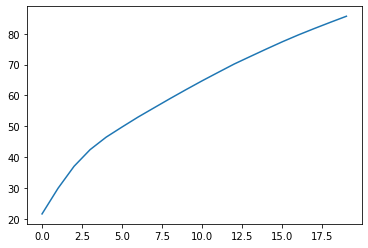

In [30]:
X_hdf = scale(house_df)
pca = PCA(n_components=20)
pca.fit(X_hdf)
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

print(var1)
plt.plot(var1)
plt.show()

In [31]:
house_df = house_df.select_dtypes(exclude=['object'])
house_df = house_df.dropna()
sklearn_pca = PCA(n_components=20)
Y = house_df['saleprice']
X = sm.add_constant(sklearn_pca.fit_transform(scale(house_df)))
results = sm.OLS(Y,X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     283.6
Date:                Tue, 10 Sep 2019   Prob (F-statistic):               0.00
Time:                        19:48:29   Log-Likelihood:                -13269.
No. Observations:                1121   AIC:                         2.658e+04
Df Residuals:                    1100   BIC:                         2.668e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.855e+05   1008.147    184.007      0.000    1.84e+05    1.87e+05
x1          2.559e+04    351.628     72.787      0.000    2.49e+04    2.63e+04
x2         -1196.9022    567.198     -2.110      0.035   -2309.814     -83.991
x3          2657.6836    612.835      4.337      0.000    1455.226    3860.141
x4         -4003.3590    705.337     -5.676      0.000   -5387.317   -2619.402
x5         -9079.1650    813.590    -11.159      0.000   -1.07e+04   -7482.801
x6         -2610.9682    898.700     -2.905      0.004   -4374.328    -847.608
x7           809.3138    911.584      0.888      0.375    -979.326    2597.953
x8           857.9454    943.787      0.909      0.364    -993.881    2709.772
x9         -6818.5009    946.126     -7.207      0.000   -8674.916   -4962.086
x10        -2738.1018    958.618     -2.856      0.004   -4619.028    -857.176
x11        -5979.0372    970.343     -6.162      0.000   -7882.969   -4075.105
x12        -2078.8472    990.414     -2.099      0.036   -4022.162    -135.532
x13         3590.7670    995.136      3.608      0.000    1638.187    5543.347
x14         4066.1358   1048.447      3.878      0.000    2008.954    6123.318
x15        -2474.3585   1053.669     -2.348      0.019   -4541.786    -406.931
x16        -1972.3159   1067.438     -1.848      0.065   -4066.760     122.128
x17        -3405.2837   1098.015     -3.101      0.002   -5559.725   -1250.843
x18         4852.6032   1133.477      4.281      0.000    2628.583    7076.624
x19         4339.7732   1153.634      3.762      0.000    2076.202    6603.345
x20        -1811.0655   1166.751     -1.552      0.121   -4100.374     478.243
==============================================================================
Omnibus:                      447.060   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65023.234
Skew:                          -0.741   Prob(JB):                         0.00
Kurtosis:                      40.282   Cond. No.                         3.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the two models it appears that the number of PCA components directly affects the r-squared and adjusted r-sqaured values. The AIC/BIC appear about the same and the F statistic is similar in each. This makes sense as the each principle component is only explaining a small amount of the variance by the 20th component, so adding or removing them only changes values slightly.